In [101]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.image_paths[idx]
        # image = Image.open(img_path).convert("RGB")  
        if self.transform:
            image = self.transform(image)
        return image



In [102]:
device = "cuda"

In [138]:
import zipfile
from io import BytesIO
from PIL import Image

def fetch_images_from_zip(zip_path):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    image_files = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.lower().endswith(image_extensions):
                with zip_ref.open(file_name) as file:
                    image_files.append(Image.open(BytesIO(file.read())))
        
    return image_files

def read_image_from_zip(zip_path, image_file):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(image_file) as file:
            image = Image.open(BytesIO(file.read()))
            return image

# zip_path = 'archive.zip'

# images = fetch_images_from_zip(zip_path)


In [139]:
def fetch_flower_images_recursive(base_path="/kaggle/input/flower"):
    all_image_paths = []
    
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']
    
    for root, dirs, files in os.walk(base_path):
        for ext in image_extensions:
            image_paths = glob.glob(os.path.join(root, ext))
            all_image_paths.extend(image_paths)
    
    return all_image_paths

image_paths = fetch_flower_images_recursive()


In [140]:
def read_images_from_folder(folder_path):
    images = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path)
                    images.append(img)
                except Exception as e:
                    print(f"Error reading {file}: {str(e)}")
    return images

folder_path = '/kaggle/input/flower'
images = read_images_from_folder(folder_path)

In [145]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),       
    transforms.ToTensor(),               
    transforms.Normalize(mean=[0.4665, 0.4251, 0.3047],
                         std=[0.2304, 0.2040, 0.2099])  
])

dataset = CustomImageDataset(images, transform=transform)

batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [146]:
mean = 0.0
std = 0.0
nb_samples = 0

for data in data_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([-5.5418e-05,  1.8274e-04,  3.0143e-05])
Std: tensor([0.9999, 0.9999, 0.9998])


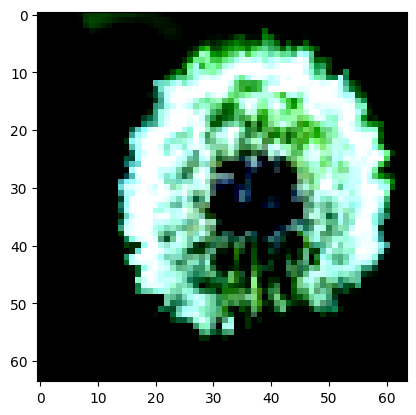

In [147]:
for i in data_loader:
    plt.imshow(i[47].permute(1,2,0))
    break

In [148]:
import torch
import math

def cosine_diffusion_schedule(diffusion_times):
    """
    Computes the signal and noise rates for a given diffusion time using cosine and sine functions.

    Parameters:
        diffusion_times (torch.Tensor): The diffusion times.

    Returns:
        noise_rates (torch.Tensor): The noise rates.
        signal_rates (torch.Tensor): The signal rates.
    """
    signal_rates = torch.cos(diffusion_times * math.pi / 2)
    noise_rates = torch.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

def offset_cosine_diffusion_schedule(diffusion_times):
    """
    Computes the signal and noise rates for a given diffusion time using an offset cosine and sine functions.

    Parameters:
        diffusion_times (torch.Tensor): The diffusion times.

    Returns:
        noise_rates (torch.Tensor): The noise rates.
        signal_rates (torch.Tensor): The signal rates.
    """
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = torch.acos(torch.tensor(max_signal_rate)) 
    end_angle = torch.acos(torch.tensor(min_signal_rate)) 
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)
    return noise_rates, signal_rates


In [149]:

diffusion_times = torch.linspace(0, 1, 100)  # Example diffusion times

noise_rates, signal_rates = cosine_diffusion_schedule(diffusion_times)
print("Cosine Diffusion Schedule")
print("Noise Rates:", noise_rates)
print("Signal Rates:", signal_rates)

offset_noise_rates, offset_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)
print("Offset Cosine Diffusion Schedule")
print("Noise Rates:", offset_noise_rates)
print("Signal Rates:", offset_signal_rates)

Cosine Diffusion Schedule
Noise Rates: tensor([0.0000, 0.0159, 0.0317, 0.0476, 0.0634, 0.0792, 0.0951, 0.1108, 0.1266,
        0.1423, 0.1580, 0.1736, 0.1893, 0.2048, 0.2203, 0.2358, 0.2511, 0.2665,
        0.2817, 0.2969, 0.3120, 0.3271, 0.3420, 0.3569, 0.3717, 0.3863, 0.4009,
        0.4154, 0.4298, 0.4441, 0.4582, 0.4723, 0.4862, 0.5000, 0.5137, 0.5272,
        0.5406, 0.5539, 0.5671, 0.5801, 0.5929, 0.6056, 0.6182, 0.6306, 0.6428,
        0.6549, 0.6668, 0.6785, 0.6901, 0.7015, 0.7127, 0.7237, 0.7346, 0.7453,
        0.7557, 0.7660, 0.7761, 0.7861, 0.7958, 0.8053, 0.8146, 0.8237, 0.8326,
        0.8413, 0.8497, 0.8580, 0.8660, 0.8738, 0.8815, 0.8888, 0.8960, 0.9029,
        0.9096, 0.9161, 0.9224, 0.9284, 0.9341, 0.9397, 0.9450, 0.9501, 0.9549,
        0.9595, 0.9638, 0.9679, 0.9718, 0.9754, 0.9788, 0.9819, 0.9848, 0.9874,
        0.9898, 0.9920, 0.9938, 0.9955, 0.9969, 0.9980, 0.9989, 0.9995, 0.9999,
        1.0000])
Signal Rates: tensor([ 1.0000e+00,  9.9987e-01,  9.9950e-01,  9.

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()

    def forward(self, x):
        return (x - x.mean(dim=(0, 2, 3), keepdim=True)) / (x.std(dim=(0, 2, 3), keepdim=True) + 1e-5)



class DiffusionModel(nn.Module):
    def __init__(self, unet,normalizer_mean,normalizer_variance):
        super(DiffusionModel, self).__init__()
        self.normalizer = Normalization()
        self.network = unet.to(device)
        self.ema_network = self.clone_model(self.network).to(device)
        self.diffusion_schedule = offset_cosine_diffusion_schedule
        self.noise_loss_tracker = nn.MSELoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-4)


        self.normalizer_mean = normalizer_mean 
        self.normalizer_variance = normalizer_variance 

    def clone_model(self, model):
        cloned_model = type(model)()
        cloned_model.load_state_dict(model.state_dict())
        return cloned_model

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        network = self.network if training else self.ema_network
        pred_noises = network(noisy_images, noise_rates ** 2)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    def train_step(self, images):
        images = self.normalizer(images)
        noises = torch.randn_like(images)
        batch_size = images.size(0)
        diffusion_times = torch.rand((batch_size, 1, 1, 1), device=images.device)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        self.optimizer.zero_grad()
        pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, training=True)
        
        noise_loss = self.noise_loss_tracker(pred_noises, noises)
        noise_loss.backward()
        self.optimizer.step()

        with torch.no_grad():
            for param, ema_param in zip(self.network.parameters(), self.ema_network.parameters()):
                ema_param.data.mul_(0.999).add_(param.data, alpha=1 - 0.999)

        return {"noise_loss": noise_loss.item()}
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        
        for step in range(diffusion_steps):
            diffusion_times = torch.ones((num_images, 1, 1, 1), device=initial_noise.device) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            
            pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates,False)
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            
            current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
        
        return pred_images
    
    def denormalize(self, images):
        # images = self.normalizer_mean + images * (self.normalizer_variance ** 0.5)
        # return torch.clamp(images, 0.0, 1.0)

        mean = self.normalizer_mean.view(-1, 3, 1, 1)
        variance = self.normalizer_variance.view(-1, 3, 1, 1)
        
        images = mean + images * (variance ** 0.5)
    
        return torch.clamp(images, 0.0, 1.0)

    def generate(self, num_images, diffusion_steps):
        initial_noise = torch.randn(num_images, 3, 64, 64).to(device)
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images.to(device))
        return generated_images


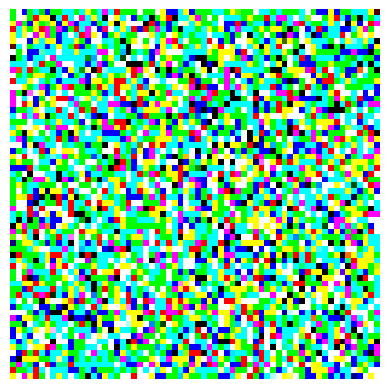

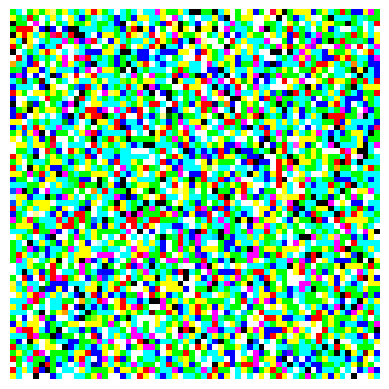

In [161]:
import numpy as np
normalizer_mean = torch.tensor([0.4665, 0.4251, 0.3047]).to(device)  #[0.5, 0.5, 0.5] 
normalizer_variance = torch.tensor([.4665, 0.4251, 0.3047]).to(device)** 2 #[0.25, 0.25, 0.25]  
model = DiffusionModel(unet,normalizer_mean, normalizer_variance).to(device)
num_images = 2
diffusion_steps = 50
generated_images = model.generate(num_images, diffusion_steps)

# To visualize the generated images
import matplotlib.pyplot as plt
for img in generated_images:
    img = img.permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [130]:
model = DiffusionModel(unet,normalizer_mean, normalizer_variance).to(device)
initial_noise = torch.randn((2, 3, 64, 64)).to(device)
diffusion_steps = 10
generated_images = model.reverse_diffusion(initial_noise, diffusion_steps)

In [153]:
import torch
import torch.nn as nn
import math

def sinusoidal_embedding(x):
    frequencies = torch.exp(
        torch.linspace(
            torch.log(torch.tensor(1.0)),
            torch.log(torch.tensor(1000.0)),
            16
        )
    ).to(x.device)
    
    angular_speeds = 2.0 * math.pi * frequencies
    
    x_expanded = x.expand(-1, -1, -1, 16)
    sin_embeds = torch.sin(angular_speeds * x_expanded)
    cos_embeds = torch.cos(angular_speeds * x_expanded)
    
    embeddings = torch.cat([sin_embeds, cos_embeds], dim=-1)
    return embeddings



In [162]:
class ResidualBlock(nn.Module):
    def __init__(self, width):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(width, width, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out

class DownBlock(nn.Module):
    def __init__(self, in_width, out_width, block_depth):
        super(DownBlock, self).__init__()
        self.block_depth = block_depth
        self.layers = nn.ModuleList([ResidualBlock(in_width) for _ in range(block_depth)])
        self.downsample = nn.Conv2d(in_width, out_width, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x,skips):
        for layer in self.layers:
            x = layer(x)
            skips.append(x)
        x = self.pool(x)
        x = self.downsample(x)
        return x, skips

class UpBlock(nn.Module):
    def __init__(self, in_width, out_width, block_depth):
        super(UpBlock, self).__init__()
        self.block_depth = block_depth
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.layers = nn.ModuleList([ResidualBlock(out_width) for _ in range(block_depth)])
        self.conv1 = nn.Conv2d(out_width+in_width, out_width, kernel_size=1)
        self.conv2 = nn.Conv2d(out_width*2, out_width, kernel_size=1)

    def forward(self, x, skips):
        x = self.upsample(x)
        for idx,layer in enumerate(self.layers):
            skip = skips.pop()
            x = torch.cat([x, skip], dim=1)
            if idx==1:
                x = self.conv2(x)
            else:
                x = self.conv1(x)
            x = layer(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=1)
        self.down1 = DownBlock(33,64, block_depth=2)
        self.down2 = DownBlock(64,128, block_depth=2)
        self.down3 = DownBlock(128,256 ,block_depth=2)
        
        self.up1 = UpBlock(256,128, block_depth=2)
        self.up2 = UpBlock(128,64, block_depth=2)
        self.up3 = UpBlock(64,33,block_depth=2)
        self.conv2 = nn.Conv2d(33, 3, kernel_size=1)

    def forward(self, noisy_images, noise_variances):
        x = self.conv1(noisy_images)
        noise_embedding = sinusoidal_embedding(noise_variances)
        noise_embedding = F.interpolate(noise_embedding, size=(64, 64), mode='nearest')
        x = torch.cat([x, noise_embedding], dim=1)
        
        skips = []
        x, skips = self.down1(x,skips)
        x, skips = self.down2(x,skips)
        x, skips = self.down3(x,skips)
        
        
        x = self.up1(x, skips)
        x = self.up2(x, skips)
        x = self.up3(x, skips)
        x = self.conv2(x)
        return x


In [163]:
unet = UNet()
unet = unet.to(device)
diffmodel = DiffusionModel(unet,normalizer_mean, normalizer_variance)

In [164]:
EPOCH = 80
for i in range(EPOCH):
    loss = []
    for batchidx,images in enumerate(data_loader):
        images = images.to(device)
        x = diffmodel.train_step(images)
        print(f"{i}_{batchidx}::{x.get('noise_loss')}",end='\r')
        loss.append(x.get('noise_loss'))

    print(f"EPOCH{i}:: loss",sum(loss)/len(images))
        


EPOCH0:: loss 1.827926050532948
EPOCH1:: loss 0.7977220836010847
EPOCH2:: loss 0.5167588693174449
EPOCH3:: loss 0.42312371188944037
EPOCH4:: loss 0.36685905165293
EPOCH5:: loss 0.3303177644583312
EPOCH6:: loss 0.30094599148089235
EPOCH7:: loss 0.2783121693540703
EPOCH8:: loss 0.2643276815387336
EPOCH9:: loss 0.2586899934844537
EPOCH10:: loss 0.25125704807314003
EPOCH11:: loss 0.24018830704418095
EPOCH12:: loss 0.22925728965889325
EPOCH13:: loss 0.2269935208288106
EPOCH14:: loss 0.22404831783338028
EPOCH15:: loss 0.215783164921132
EPOCH16:: loss 0.21634828570214185
EPOCH17:: loss 0.21094330603426154
EPOCH18:: loss 0.211104348979213
EPOCH19:: loss 0.2069486596367576
EPOCH20:: loss 0.20353703387081623
EPOCH21:: loss 0.20033225213939493
EPOCH22:: loss 0.19726414944637904
EPOCH23:: loss 0.20410152761773628
EPOCH24:: loss 0.193510117855939
EPOCH25:: loss 0.19310655749656938
EPOCH26:: loss 0.19213551011952487
EPOCH27:: loss 0.19035167060792446
EPOCH28:: loss 0.18801405822688882
EPOCH29:: loss

In [ ]:
num_images = 1
diffusion_steps = 20
generated_images = diffmodel.generate(num_images, diffusion_steps)

for img in generated_images:
    img = img.permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [165]:
torch.save(diffmodel.state_dict(), "/kaggle/working/model2.pth")